In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [185]:
backpack = pd.read_csv('./data/train.csv')
test_backpack = pd.read_csv('./data/test.csv')
backpack.drop('id', axis=1, inplace=True)

In [186]:
backpack.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


# Treating Missing Value

In [187]:
backpack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 290295 non-null  object 
 1   Material              291653 non-null  object 
 2   Size                  293405 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    292556 non-null  object 
 5   Waterproof            292950 non-null  object 
 6   Style                 292030 non-null  object 
 7   Color                 290050 non-null  object 
 8   Weight Capacity (kg)  299862 non-null  float64
 9   Price                 300000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 22.9+ MB


## Delete Rows with 3 Nan value and More

In [188]:
threshold = 3
mask = backpack.isna().sum(axis=1) >= threshold
filtered_backpack = backpack[mask]

In [189]:
clean_backpack1 = backpack[~mask]

## Remove Missing Value for Nominal Categories

In [190]:
nominal_col = ['Brand', 'Material', 'Style', 'Color']
clean_backpack2 = clean_backpack1.dropna(subset=nominal_col)

In [191]:
clean_backpack2.isna().sum()

Brand                      0
Material                   0
Size                    6083
Compartments               0
Laptop Compartment      6706
Waterproof              6490
Style                      0
Color                      0
Weight Capacity (kg)      33
Price                      0
dtype: int64

## Missing Value Imputation

In [192]:
size_labels = clean_backpack1['Size'].sort_values(ascending=False).unique().tolist()

In [193]:
size_label_dic = {k:i for i, k in enumerate(size_labels)}
if np.nan in size_label_dic.keys():
    size_label_dic[np.nan] = np.nan

In [194]:
laptop_compartment_dic = {k:i for i, k in enumerate(clean_backpack1['Laptop Compartment'].sort_values(ascending=False).unique().tolist())}
if np.nan in laptop_compartment_dic.keys():
    laptop_compartment_dic[np.nan] = np.nan

In [195]:
waterproof_dic = {k:i for i, k in enumerate(clean_backpack1['Waterproof'].sort_values(ascending=False).unique().tolist())}
if np.nan in waterproof_dic.keys():
    waterproof_dic[np.nan] = np.nan

In [196]:
waterproof_dic

{'Yes': 0, 'No': 1, nan: nan}

In [197]:
to_impute_obj_col = ['Size', 'Laptop Compartment', 'Waterproof']
to_impute_num_col = ['Compartments', 'Weight Capacity (kg)']

In [198]:
before_backpack = clean_backpack2.copy()

before_backpack['Waterproof'] = before_backpack['Waterproof'].map(waterproof_dic)
before_backpack['Laptop Compartment'] = before_backpack['Laptop Compartment'].map(laptop_compartment_dic)
before_backpack['Size'] = before_backpack['Size'].map(size_label_dic)

In [199]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights='distance')

imputed_backpack = imputer.fit_transform(before_backpack[list(to_impute_obj_col+to_impute_num_col)])

In [200]:
imputed_df = pd.DataFrame(imputed_backpack, columns=to_impute_obj_col + to_impute_num_col, index=before_backpack.index)

In [201]:
imputed_df.isnull().sum()

Size                    0
Laptop Compartment      0
Waterproof              0
Compartments            0
Weight Capacity (kg)    0
dtype: int64

In [228]:
final_backpack = before_backpack.copy()
final_backpack[to_impute_obj_col + to_impute_num_col] = round(imputed_df)

In [227]:
round(2.1)

2

In [229]:
print(final_backpack.isna().sum())

Brand                   0
Material                0
Size                    0
Compartments            0
Laptop Compartment      0
Waterproof              0
Style                   0
Color                   0
Weight Capacity (kg)    0
Price                   0
dtype: int64


In [230]:
final_backpack['Size'].unique()

array([1., 0., 2.])

In [231]:
def reverse_dic(dic):
    return {v: k for k, v in dic.items()}

In [232]:
reverse_dic(waterproof_dic)

{0: 'Yes', 1: 'No', nan: nan}

In [233]:
final_backpack['Waterproof'] = final_backpack['Waterproof'].map(reverse_dic(waterproof_dic))
final_backpack['Laptop Compartment'] = final_backpack['Laptop Compartment'].map(reverse_dic(laptop_compartment_dic))
final_backpack['Size'] = final_backpack['Size'].map(reverse_dic(size_label_dic))

In [236]:
final_backpack.isnull().sum()

Brand                   0
Material                0
Size                    0
Compartments            0
Laptop Compartment      0
Waterproof              0
Style                   0
Color                   0
Weight Capacity (kg)    0
Price                   0
dtype: int64

# Regression

In [240]:
to_onehot_col = final_backpack.drop(list(to_impute_obj_col + to_impute_num_col + ['Price']), axis=1).columns.tolist()

In [241]:
to_onehot_col

['Brand', 'Material', 'Style', 'Color']

In [257]:
ordinal_categories = {
    'Waterproof': ['Yes', 'No'],
    'Size': ['Small', 'Medium', 'Large'],
    'Laptop Compartment': ['Yes', 'No']
}

In [258]:
X = final_backpack.drop('Price', axis=1)
y = final_backpack['Price']

In [253]:
X.columns

Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)'],
      dtype='object')

In [256]:
to_onehot_col, ordinal_categories, to_impute_num_col

(['Brand', 'Material', 'Style', 'Color'],
 {'Waterproof': ['Yes', 'No'],
  'Size': ['Small', 'Medium', 'Large'],
  'Laptop_Compartment': ['Yes', 'No']},
 ['Compartments', 'Weight Capacity (kg)'])

In [284]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(transformers=[
    ('onehot encoding', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), to_onehot_col),
    ("ordinal", OrdinalEncoder(
            categories=[ordinal_categories[col] for col in ordinal_categories],
        ), list(ordinal_categories.keys())),]
    , remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

X_transformed = transformer.fit_transform(X)

In [290]:
X_transformed.head()

,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Waterproof,Size,Laptop Compartment,Compartments,Weight Capacity (kg)
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,12.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,27.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,17.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,8.0,13.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,18.0


In [278]:
X_transformed = (X_transformed - X_transformed.mean())/X_transformed.std()

In [287]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
regressor = RandomForestRegressor(n_estimators=40, random_state=42, oob_score=True)
lr = LinearRegression()

In [288]:
regressor.fit(X_train, y_train)
lr.fit(X_train, y_train)

LinearRegression()

In [291]:
regressor.score(X_train, y_train), lr.score(X_train, y_train)

(0.7687158738281745, 0.0011760395487233621)

In [292]:
regressor.score(X_test, y_test), lr.score(X_test, y_test)

(-0.16533976100516656, 0.00043712246290517065)

In [298]:
y_pred = lr.predict(X_test)

In [293]:
regressor.oob_score_

-0.2097258332242733

In [299]:
error = y_test - y_pred

(array([  114.,  1060.,  3620.,  7571., 11495., 12279.,  9558.,  5232.,
         1954.,   267.]),
 array([77.13534246, 77.96094692, 78.78655138, 79.61215585, 80.43776031,
        81.26336477, 82.08896924, 82.9145737 , 83.74017817, 84.56578263,
        85.39138709]),
 <BarContainer object of 10 artists>)

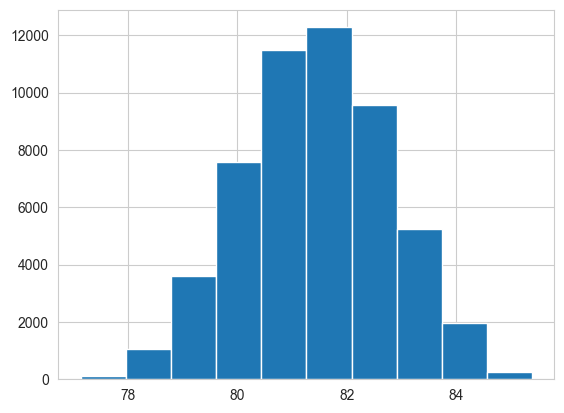

In [300]:
plt.hist(y_pred)